## Car Price Prediction Project


_**Importing the required libraries, packages & dataset**_

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
%matplotlib inline
import pickle
import warnings
warnings.filterwarnings('ignore')

_**Changing The Default Working Directory Path**_

In [2]:
os.chdir('C:\\Users\\mural\\Desktop\\New folder')
df=pd.read_csv('dataset.csv')

## Data Cleaning:

_**Viewing the Dataset fopt identifying the unwanted columns**_

In [3]:
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


_**Drooping the `unnamed: 0`,`Location` and `New_Price` Column since it is not much important for the prediction**_

In [4]:
df.drop(['Unnamed: 0','Location','New_Price'],axis=1,inplace=True)

_**Checking the Null Values of all the Columns in the Dataset**_

In [5]:
df.isna().sum()

Name                  0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               2
Engine               36
Power                36
Seats                42
Price                 0
dtype: int64

_**There are several cars in the dataset, some of them with a count higher than 1.Sometimes the resale value of a car also 
depends on manufacturer of the car.so,here extracting  the manufacturer name form this column and adding it to the dataset**_

In [6]:
manufacturer=df['Name'].str.split(' ',expand=True)
df['Manufacturer']=manufacturer[0]

_**The `Year` Column from the dataset has no significant on its own so calculating the years of cars used till now and adding it to the adatset**_

In [7]:
curr_time = datetime.datetime.now()
df['New Year']= df['Year'].apply(lambda x: curr_time.year - x)

_**Dropping the `name` and `Year` column since the needed data is extracted from it and added to the dataset in separate columns as `Manufacturer` and `New year`**_

In [8]:
df.drop(['Name','Year'],axis=1,inplace=True)

_**The `Mileage` column defines the mileage of the car which affect the price of the car during the sales.So that removing CC and extracting the numerical values form the `Mileage` column and Since it has missing values,filling out the missing values with the mean &  modifying the column with the values**_

In [9]:
Mileage=df['Mileage'].str.split(' ',expand=True)
df['Mileage']=pd.to_numeric(Mileage[0],errors= 'coerce')
df['Mileage'].fillna(df['Mileage'].astype('float').mean(),inplace=True)

_**The `Engine`column defines the mileage of the car which affect the price of the car during the sales.So that removing CC and extracting the numerical values form the `Engine` column and  Since it has missing values,filling out the missing values with the mean &  modifying the column with the values**_

In [10]:
Engine=df['Engine'].str.split(' ',expand=True)
df['Engine']=pd.to_numeric(Engine[0],errors= 'coerce')
df['Engine'].fillna(df['Engine'].astype('float').mean(),inplace=True)

_**The `Power`column defines the mileage of the car which affairs the price of the car during the sales.So that removing bhp extracting the numerical values form the `Power` column and Since it has missing values,filling out the missing values with the mean &  modifying the column with the values**_

In [11]:
Power=df['Power'].str.split(' ',expand=True)
df['Power']=pd.to_numeric(Power[0],errors= 'coerce')
df['Power'].fillna(df['Power'].astype('float').mean(),inplace=True)

In [12]:
df['Seats'].fillna(df['Seats'].astype('float').mean(),inplace=True)

In [13]:
df.isna().sum()

Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
Manufacturer         0
New Year             0
dtype: int64

## Data Visualization:

_**Plotting the Bar graph with count of cars based on the `Manufacturers` and confirm that there are no null values and identify all unique values from the `Manufacture` and saving the PNG file**_

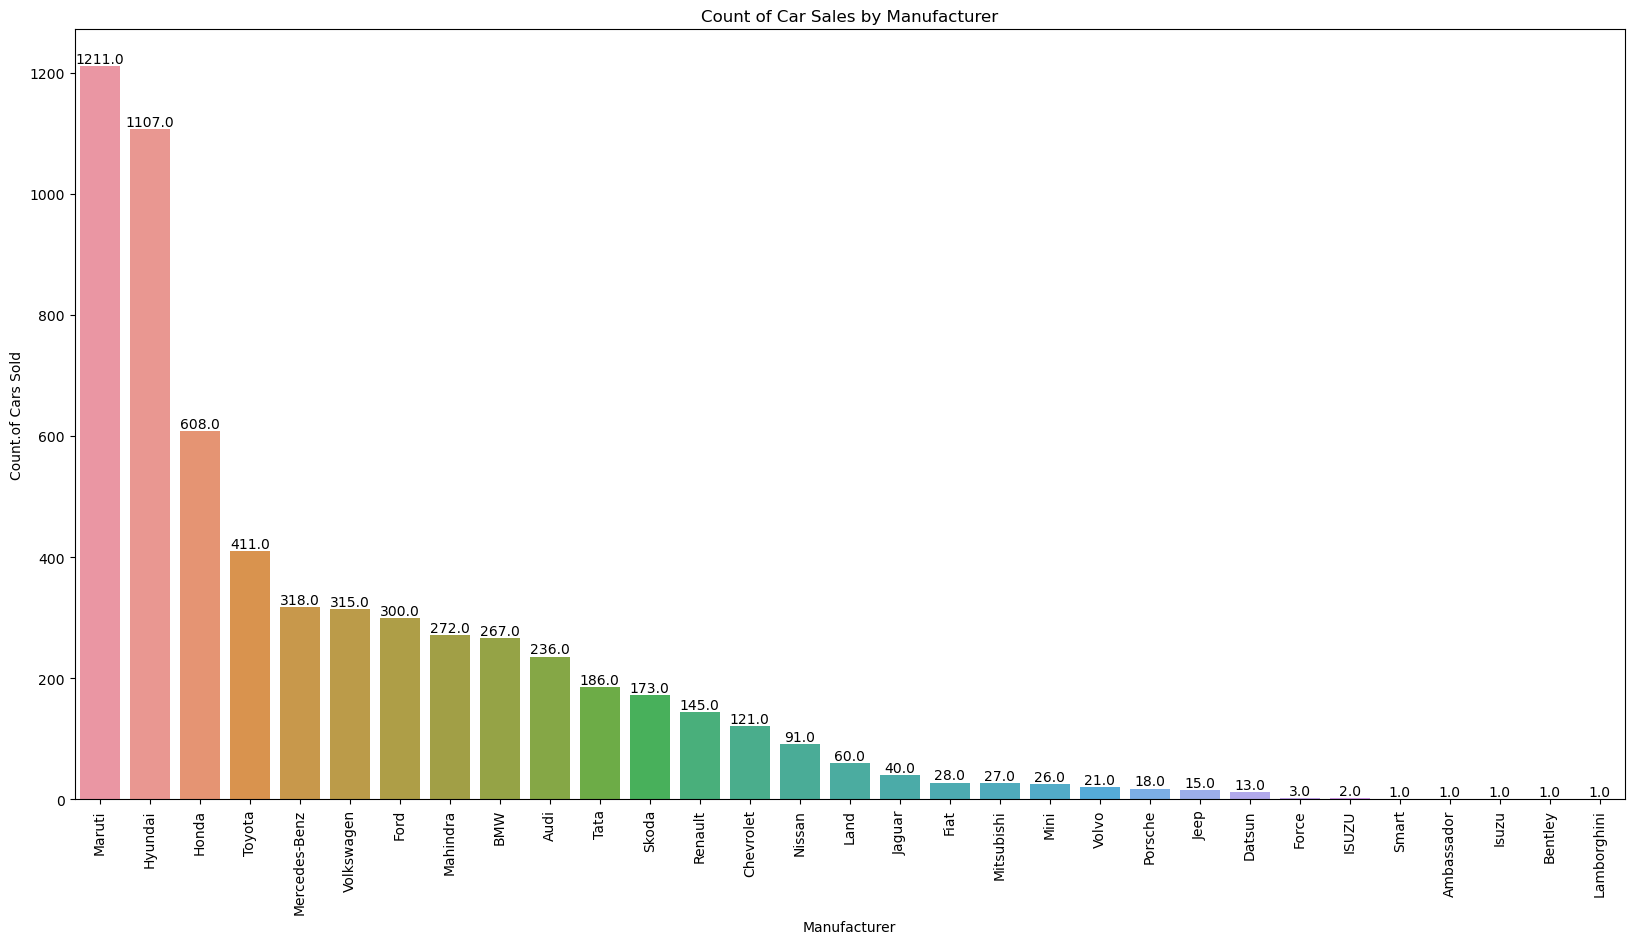

In [14]:
plt.rcParams['figure.figsize']=20,10
cars= df['Manufacturer'].value_counts()
plot=sns.barplot(x = cars.index,y=cars.values,data=df)
plt.xticks(rotation= 90)
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                  ha ='center', va= 'center',xytext =(0,5),textcoords ='offset points')
plt.title('Count of Car Sales by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Count.of Cars Sold')
plt.savefig('Count of cars.png')
plt.show()

_**Getting the Correlation Values from all the numeric columns from the dataset and checking for correlation using Seaborn Heatmap & saving the PNG File**_

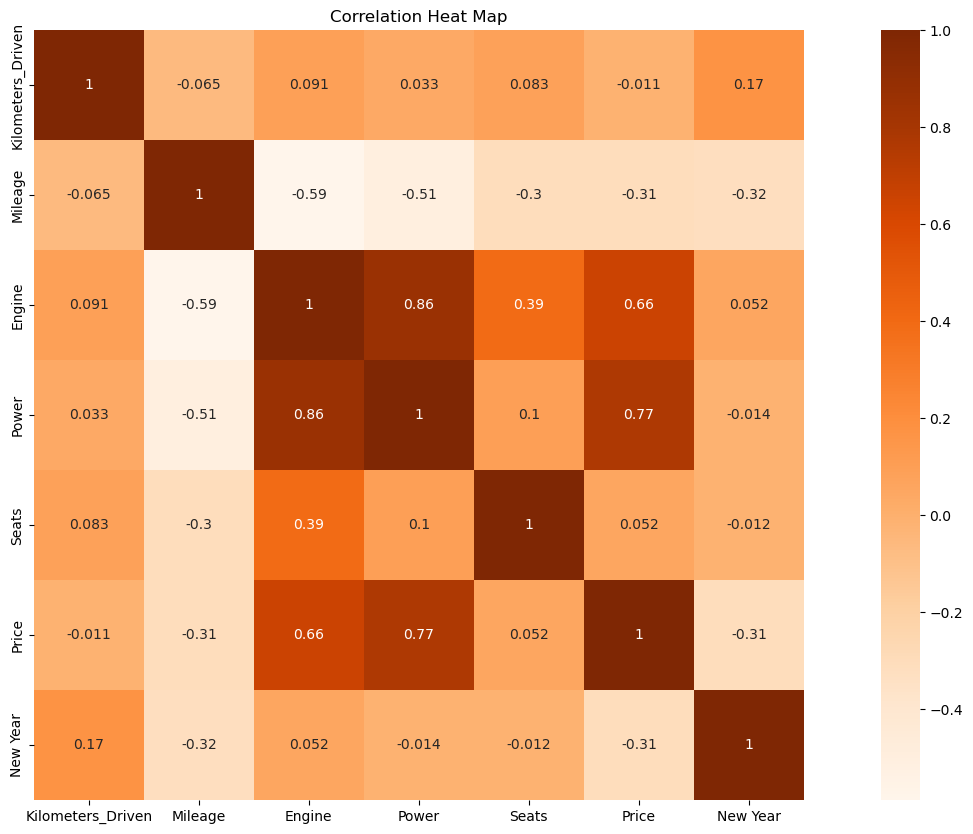

In [15]:
sns.heatmap(df.corr(),annot=True,cmap='Oranges',square=True,cbar=True)
plt.title('Correlation Heat Map')
plt.savefig('Correlation Heat Map.png')
plt.show() 

_**Assigning the dependent and independent variable**_

In [16]:
x=df.drop(['Price'],axis=1)
y=df['Price']

## Data Preprocessing:

_**Splitting the dependent and independent variable into training and test dataset using train test split**_

In [17]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=45)

_**Creating the dummy columns for all the categorical columns such as `Manufacturer`, `Fuel_Type`, `Owner_type`, `transmission` in the train independent dataset and getting the dimensions of the train dataset for cross_check**_

In [18]:
x_train= pd.get_dummies(x_train,columns = ['Manufacturer','Fuel_Type','Owner_Type','Transmission'],drop_first = True)
print(x_train.shape)

(4213, 42)


_**Creating the dummy columns for all the categorical columns such as `Manufacturer`, `Fuel_Type`, `Owner_type`, `transmission` in the test independent dataset and getting the dimensions of the test dataset for cross_check**_

In [19]:
x_test = pd.get_dummies(x_test,columns = ['Manufacturer','Fuel_Type','Owner_Type','Transmission'],drop_first = True)
print(x_test.shape)

(1806, 38)


_**By the dimensional checking its so evident that the dummy column creation is different in training and test independent data and so that filling in all the missing columns of independent data with 0**_ 

In [20]:
miss_col= set(x_train.columns) - set(x_test.columns)
for col in miss_col:
    x_test[col] = 0
x_test = x_test[x_train.columns]

_**Now after processing the dimension of the column of both tarining and test independent data are same**_

In [21]:
print(x_train.shape)
print(x_test.shape)

(4213, 42)
(1806, 42)


_**standardizing the independent training variable and independent test variable of the dataset**_

In [22]:
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.fit_transform(x_test)

## Model Fitting:

_**Defining the Function for the ML algorithms using GridSearchCV Algorithm and Predicting the Dependent Variable by fitting the given model and create the pickle file of the model with the given Algo_name. Further getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format,Mean Absolute error and Mean Squared error between the predicted values and dependent test dataset.**_

In [23]:
def FitModel (x,y,algo_name,algorithm,GridSearchParam,cv):
    np.random.seed(10)
    grid=GridSearchCV(estimator= algorithm,param_grid=GridSearchParam,cv=cv,
                     scoring='r2',verbose=0,n_jobs=-1)
    grid_result=grid.fit(x_train,y_train)
    pred=grid_result.predict(x_test)
    best_params=grid_result.best_params_
    pickle.dump(grid_result,open(algo_name,'wb'))
    print('Algorithm Name:',algo_name)
    print('Best Param:',best_params)
    print('R2 Score {}%'.format(100* r2_score(y_test,pred)))
    print('Mean Absolute error :',mean_absolute_error(y_test,pred))
    print('Root Mean Error :',mean_squared_error(y_test,pred))

_**Running the function with empty parameters since the Linear Regression model doesn't need any special parameters and fitting the Linear Regression Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format between the predicted values and dependent test dataset and also the pickle file with the name Linear Regression.**_

In [24]:
params={}
FitModel(x,y,'Linear Regression',LinearRegression(),params,cv=10)

Algorithm Name: Linear Regression
Best Param: {}
R2 Score 76.90457787320157%
Mean Absolute error : 2.9688979955213295
Root Mean Error : 28.666484566645543


_**Running the function with empty parameters since the Lasso model doesn't need any special parameters and fitting the Linear Regression Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format between the predicted values and dependent test dataset and also the pickle file with the name Lasso.**_

In [25]:
FitModel(x,y,'Lasso',Lasso(),params,cv=10)

Algorithm Name: Lasso
Best Param: {}
R2 Score 72.26180392554386%
Mean Absolute error : 3.3695924404312683
Root Mean Error : 34.429185373162625


_**Running the function with empty parameters since the Ridge model doesn't need any special parameters and fitting the Linear Regression Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format between the predicted values and dependent test dataset and also the pickle file with the name Ridge.**_

In [26]:
FitModel(x,y,'Ridge',Ridge(),params,cv=10)

Algorithm Name: Ridge
Best Param: {}
R2 Score 76.56033098691181%
Mean Absolute error : 2.9792346265440095
Root Mean Error : 29.093770459008212


_**Running the function with some appropriate parameters and fitting the Random Forest Regressor Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format between the predicted values and dependent test dataset and also the pickle file with the name Random Forest.**_

In [27]:
params={'n_estimators' : [44,109,314],
        'random_state' : [45]}
FitModel(x,y,'random Forest',RandomForestRegressor(),params,cv=10)

Algorithm Name: random Forest
Best Param: {'n_estimators': 109, 'random_state': 45}
R2 Score 89.23129777279568%
Mean Absolute error : 1.8269114633905619
Root Mean Error : 13.366321451243701


_**Running the function with some appropriate parameters and fitting the Extra Trees Regressor Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format between the predicted values and dependent test dataset and also the pickle file with the name Extra Trees.**_

In [28]:
params={'n_estimators' : [44,109,314],
        'random_state' : [45]}
FitModel(x,y,'Extra Trees',ExtraTreesRegressor(),params,cv=10)

Algorithm Name: Extra Trees
Best Param: {'n_estimators': 314, 'random_state': 45}
R2 Score 91.2684112394556%
Mean Absolute error : 1.6592943814320273
Root Mean Error : 10.837816822408508


_**Running the function with some appropriate parameters and fitting the XGBoost Regressor Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format between the predicted values and dependent test dataset and also the pickle file with the name XGBoost.**_

In [29]:
FitModel(x,y,'XG Boost',XGBRegressor(),params,cv=10)

Algorithm Name: XG Boost
Best Param: {'n_estimators': 44, 'random_state': 45}
R2 Score 88.46083787618653%
Mean Absolute error : 1.8590134571748451
Root Mean Error : 14.322631174188217


_**Running the function with empty parameters since the CatBoost Regressor model doesn't need any special parameters and fitting the CatBoost Regressor Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format between the predicted values and dependent test dataset and also the pickle file with the name CatBoost.**_

In [30]:
params ={'verbose': [0]}
FitModel(x,y,'Cat Boost',CatBoostRegressor(),params,cv=10)

Algorithm Name: Cat Boost
Best Param: {'verbose': 0}
R2 Score 91.79030173033371%
Mean Absolute error : 1.6527314141407436
Root Mean Error : 10.190036252731161


_**Running the function with empty parameters since the LightGBM Regressor model doesn't need any special parameters and fitting the LightGBM Regressor Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format between the predicted values and dependent test dataset and also the pickle file with the name LightGBM.**_

In [31]:
params={}
FitModel(x,y,'Light GBM',LGBMRegressor(),params,cv=10)

Algorithm Name: Light GBM
Best Param: {}
R2 Score 88.81763190646117%
Mean Absolute error : 1.8329374062863661
Root Mean Error : 13.879771524072929


## Boosting The Model:

_**Defining the Function for the ML algorithms using GridSearchCV Algorithm and boosting the model  using AdaBoostRegressor Algorithm and Predicting the Dependent Variable by fitting the given model and create the pickle file of the model with the given Algo_name. Further getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format,Mean Absolute error and Mean Squared error between the predicted values and dependent test dataset.**_

In [32]:
def BoostModel(x,y,algo_name,algorithm,GridSearchParams,cv):
    np.random.seed(10)
    grid = GridSearchCV(estimator = algorithm, param_grid = GridSearchParams, cv = cv,
                       scoring = 'r2', verbose = 0,n_jobs = -1)
    grid_result = grid.fit(x_train,y_train)
    AB = AdaBoostRegressor(base_estimator = grid_result,learning_rate = 1)
    boostmodel = AB.fit(x_train,y_train)
    pred = boostmodel.predict(x_test)
    pickle.dump(boostmodel,open(algo_name,'wb'))
    print('Algorithm Name : ',algo_name,'\n')
    print('Percentage of R2 Score : {} %'.format(100 * r2_score(y_test,pred)),'\n')
    print('Mean Absolute Error : ',mean_absolute_error(y_test,pred),'\n')
    print('Root Mean Squared Error : ',sqrt(mean_squared_error(y_test,pred)),'\n')

_**Running the function with empty parameters and Boosting the Linear Regression Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format between the predicted values and dependent test dataset and also the pickle file with the name Linear Regression 1.**_

In [33]:
params={}
BoostModel(x,y,'Linear Regression 1',LinearRegression(),params,cv=10)

Algorithm Name :  Linear Regression 1 

Percentage of R2 Score : -3.2876724438975355e+20 % 

Mean Absolute Error :  1257646790.8569725 

Root Mean Squared Error :  20200798535.915405 



_**Running the function with empty parameters and Boosting the Lasso Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format between the predicted values and dependent test dataset and also the pickle file with the name Lasso 1.**_

In [34]:
BoostModel(x,y,'Lasso 1',Lasso(),params,cv=10)

Algorithm Name :  Lasso 1 

Percentage of R2 Score : 46.588221386833396 % 

Mean Absolute Error :  4.952642083713241 

Root Mean Squared Error :  8.142219138535896 



_**Running the function with empty parameters and Boosting the Ridge Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format between the predicted values and dependent test dataset and also the pickle file with the name Ridge 1.**_

In [35]:
BoostModel(x,y,'Ridge 1',Ridge(),params,cv=10)

Algorithm Name :  Ridge 1 

Percentage of R2 Score : 64.3643619929981 % 

Mean Absolute Error :  3.6808781828019868 

Root Mean Squared Error :  6.6506874097192545 



_**Running the function with empty parameters and Boosting the Random Forest Regressor Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format between the predicted values and dependent test dataset and also the pickle file with the name Random Forest 1.**_

In [36]:
params={'n_estimators' : [44,109,314],
        'random_state' : [45]}
BoostModel(x,y,'Random Forest 1',RandomForestRegressor(),params,cv=10)

Algorithm Name :  Random Forest 1 

Percentage of R2 Score : 89.0139657664353 % 

Mean Absolute Error :  1.7901503217097143 

Root Mean Squared Error :  3.692706072833081 



_**Running the function with empty parameters and Boosting the Extra Trees Regressor Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format between the predicted values and dependent test dataset and also the pickle file with the name Extra Trees 1.**_

In [37]:
BoostModel(x,y,'Extra Trees 1',ExtraTreesRegressor(),params,cv=10)

Algorithm Name :  Extra Trees 1 

Percentage of R2 Score : 91.59174841007513 % 

Mean Absolute Error :  1.6556810006005844 

Root Mean Squared Error :  3.230554824405723 



For,further predictions use the model with the highest r2 score and load the pickle file with the format as <span style='color:Green'>Pickle.load(open(algo_name,'rb))</span>**_  